<a href="https://colab.research.google.com/github/erickucl/3D-Machine-Learning/blob/master/Semantic_Segmentation_for_panoramas_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Panorama Semantic Segmentation for point Cloud Classification**

###This notebook explains the process steps for loading and generating a complete semantic segmentation for point cloud classification using automatic learning techniques.

#downloading the image from dropbox
To Do: Change the route to Github.

In [2]:
#libraries
import numpy as np
from os.path import basename
#libs 2
from matplotlib import pyplot as plt
import pathlib
import os
import cv2 
import glob
import argparse
import sys
import time
from os.path import exists, join, basename, splitext

In [3]:
def load_files(panorama_url_op):
  #downloading the image from dropbox
  if panorama_url_op == 'a1':
    #panorama base image
    panorama_url = 'https://www.dropbox.com/s/nmeyfubiotlnqpp/Job002-fill.jpg'
    sph_file = basename(panorama_url)
    !wget -q -O $sph_file $panorama_url
  elif panorama_url_op == 'a2':
    panorama_url = 'https://www.dropbox.com/s/0xm5iwu9rlayjzu/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_equirectangular_domain_rgb.png'
    sph_file = basename(panorama_url)
    !wget -q -O $sph_file $panorama_url

  #panorama to prespective code
  #from https://github.com/fuenwang/Equirec2Perspec
  Equirec2Perspec_url = 'https://www.dropbox.com/s/enfc7nd6kb67ppv/Equirec2Perspec.py'
  eq_file = basename(Equirec2Perspec_url)
  !wget -q -O $eq_file $Equirec2Perspec_url

  #perspective to panorama code
  #from https://github.com/fuenwang/Equirec2Perspec
  Perspec2Equirec_url = 'https://www.dropbox.com/s/s65kred2wmqbl1f/Perspec2Equirec.py'
  psp_file = basename(Perspec2Equirec_url)
  !wget -q -O $psp_file $Perspec2Equirec_url

  #centroids spherical coordinates, from Icosahedral regular 
  centroids_url = 'https://www.dropbox.com/s/3n1ip51ah2fit4c/centroids.npy'
  centroids_file = basename(centroids_url)
  !wget -q -O $centroids_file $centroids_url
  return sph_file, eq_file, psp_file, centroids_file

#Loading the centroids spherical coordinates into an array.
This will be used to create the tangential central points of the Gnomonic images

In [4]:
#Centroids from https://colab.research.google.com/drive/1G0spAIr4Ysg6nUQKMrFEKI80KccZDdg4#scrollTo=DuFTxyR1a1is
def centroids_to_array():
  centroids = np.load(centroids_file, mmap_mode='r')
  print("Triangles and centroids on the Icosahedron: ", centroids.shape[0])
  return centroids

#Parameters configuration
In this stage, we define the Project path linked to the Google Drive folder to store the projected gnomonic, segmented and reprojected images

In [5]:
# load and folder creation
def path_creation(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def project_load(folder_num):
  project_path = "/content/drive/My Drive/Colab Notebooks/research-project/" + folder_num #change picx for different folders
  sample_path = project_path + "sample/"
  segmented_path =project_path + "segmented/"
  out_path =project_path + "out/"
  folders = [project_path, sample_path, segmented_path, out_path]
  
  for path in folders:
    path_creation(path)
     
  print(project_path)
  return project_path, sample_path, segmented_path, out_path
#print ok

Function for displaying imgs

In [6]:
def plot_img_from_file(file):
  plt_sample = cv2.imread(file)
  plt.imshow(plt_sample);

def plot_img_from_np(file):
  plt.imshow(file);



##Gnomonic (pinhole) image creation
AFTER setting the parameters of the project and reprojections, using the centroids coordinates and the GetPerspective code, this part generates the Tangential images from the equirectangular sphere image.

In [7]:
def gnomonic_generation():
  i = 1
  for coord in interval:
    img = equ.GetPerspective(fov, coord[5], coord[4], resolution*3, resolution*4) #fov, theta, phi, h, w
    #gnomonic_data = np.append(gnomonic_data,[img], axis=0)
    cv2.imwrite(sample_path+"gnomonic{0}.png".format(str(i).zfill(3)),img)
    i = i + 1

# CSAILVision semantic segmention models
integration for image classification

This is a semantic segmentation notebook using an [ADE20K](http://groups.csail.mit.edu/vision/datasets/ADE20K/) pretrained model from the open source project [CSAILVision/semantic-segmentation-pytorch](https://github.com/CSAILVision/semantic-segmentation-pytorch).

 Clone repo and install dependencies:

In [8]:
def CSAILVision_clone():
  git_repo_url = 'https://github.com/CSAILVision/semantic-segmentation-pytorch.git'
  project_name = splitext(basename(git_repo_url))[0]
  if not exists(project_name):
    # clone and install dependencies
    !git clone -q $git_repo_url
    #!cd $project_name && pip install -q -r requirement.txt

  sys.path.append(project_name)
  return project_name

## Download a pretrained model

According to [https://github.com/CSAILVision/semantic-segmentation-pytorch#performance](https://github.com/CSAILVision/semantic-segmentation-pytorch#performance),  **UperNet101** was the best performing model. We will use it as the pretrained model:

In [9]:
def CSAILVision_model():
  ENCODER_NAME = 'resnet101'
  DECODER_NAME = 'upernet'
  PRETRAINED_ENCODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/encoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)
  PRETRAINED_DECODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/decoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)

  pretrained_encoder_file = basename(PRETRAINED_ENCODER_MODEL_URL)
  if not exists(pretrained_encoder_file):
    !wget -q $PRETRAINED_ENCODER_MODEL_URL
  pretrained_decoder_file = basename(PRETRAINED_DECODER_MODEL_URL)
  if not exists(pretrained_decoder_file):
    !wget -q $PRETRAINED_DECODER_MODEL_URL
  
  return ENCODER_NAME, DECODER_NAME, pretrained_encoder_file, pretrained_decoder_file

## Prepare model

Load the pretrained model:

In [10]:
def CSAILVision_load():
  # options
  options = SimpleNamespace(fc_dim=2048,
                            num_class=150,
                            imgSizes = [300, 400, 500, 600],
                            imgMaxSize=1000,
                            padding_constant=8,
                            segm_downsampling_rate=8)

  # create model
  builder = ModelBuilder()
  net_encoder = builder.build_encoder(arch=ENCODER_NAME, weights=pretrained_encoder_file,
                                      fc_dim=options.fc_dim)
  net_decoder = builder.build_decoder(arch=DECODER_NAME, weights=pretrained_decoder_file,
                                      fc_dim=options.fc_dim, num_class=options.num_class, use_softmax=True)
  segmentation_module = SegmentationModule(net_encoder, net_decoder, torch.nn.NLLLoss(ignore_index=-1))
  segmentation_module = segmentation_module.eval()
  torch.set_grad_enabled(False)

  if torch.cuda.is_available():
    segmentation_module = segmentation_module.cuda()

  # test on a given image
  return options, segmentation_module


def test(test_image_name):
  dataset_test = TestDataset([{'fpath_img': test_image_name}], options, max_sample=-1)
  
  batch_data = dataset_test[0]
  segSize = (batch_data['img_ori'].shape[0], batch_data['img_ori'].shape[1])
  img_resized_list = batch_data['img_data']
  
  scores = torch.zeros(1, options.num_class, segSize[0], segSize[1])
  if torch.cuda.is_available():
    scores = scores.cuda()

  for img in img_resized_list:
    feed_dict = batch_data.copy()
    feed_dict['img_data'] = img
    del feed_dict['img_ori']
    del feed_dict['info']
    if torch.cuda.is_available():
      feed_dict = {k: o.cuda() for k, o in feed_dict.items()}

    # forward pass
    pred_tmp = segmentation_module(feed_dict, segSize=segSize)
    scores = scores + pred_tmp / len(options.imgSizes)

    confidence, pred = torch.max(scores, dim=1)


  return pred.squeeze(0).cpu().numpy(), confidence.squeeze(0).cpu().numpy()
  #confidence array is for the final weight integration 

 Evaluating on the "sample" folder - set of gnomonic images and storing in "segmented" folder

In [11]:
def semantic_segmentation_resnet101():
  seg_files = glob.glob (sample_path+"*.png")
  i=0
  for pic in seg_files:
    img = sample_path+"gnomonic{0}.png".format(str(i+1).zfill(3))

    t = time.time()
    pred, confidence = test(img) #confidence numpy array not used yet 

    # color encoder 
    pred_color = colorEncode(pred, loadmat(os.path.join(project_name, 'data/color150.mat'))['colors'])

    #store images as "segmented"
    cv2.imwrite(segmented_path+"segmented{0}.png".format(str(i+1).zfill(3)),pred_color)

    #store confidence as a np 3d array
    confidence = confidence[:, :, np.newaxis]
    confidence = np.dstack( ( confidence, np.zeros((confidence.shape[0], confidence.shape[1])) ) )
    confidence = np.dstack( ( confidence, np.zeros((confidence.shape[0], confidence.shape[1])) ) )
    np.save(segmented_path+"segmented{0}.npy".format(str(i+1).zfill(3)),confidence)
    print(i)
    i=i+1



Now we have the segmented image array and the confidence array. The last is stored as a npy file. we need to reproject this array into the equirectangular panorama size and then use the torch.max to extract the maximum prediction for each pixel according to the different tangential images... seems possible to do using tensors in torch. The problem is that for the segmentation I need to store the classes in different arrays.

The next code is just for visualisation...

To improve the segmentation, we also need to store the raw segmented panorama in png and the confidence array

In [12]:
def panorama_size():
  panorama = cv2.imread(sph_file)
  panorama_width = panorama.shape[1]
  panorama_height = panorama.shape[0]
  panorama_channels = panorama.shape[2]
  return panorama, panorama_height, panorama_width, panorama_channels

def panorama_to_segmentation(sph_file):

  if panorama_width > 4000:
    #resize img
    scale_percent = 35 # percent of original size
    width = int(panorama_width * scale_percent / 100)
    height = int(panorama_height * scale_percent / 100)
    dim_resized_pan = (width, height)
    panorama_to_seg = cv2.resize(panorama, dim_resized_pan)
    cv2.imwrite('scaled_panorama.png',panorama_to_seg)
    sph_file_resized = 'scaled_panorama.png'
    t = time.time()
    pred_sph, confidence_sph = test(sph_file_resized)
  else:
    t = time.time()
    pred_sph, confidence_sph = test(sph_file)

  # color encoder 
  pred_color = colorEncode(pred_sph, loadmat(os.path.join(project_name, 'data/color150.mat'))['colors'])

  #resize panorama
  pred_color = cv2.resize(pred_color, (panorama_width, panorama_height))
  print(pred_color.shape)

  pred_color_resized = cv2.resize(pred_color, (panorama_width, panorama_height), interpolation = cv2.INTER_AREA)

  #store images as "segmented"
  cv2.imwrite(out_path+"reprojected061.png",pred_color_resized)

  #confidence resize and save as  as array
  confidence_sph = confidence_sph[:, :, np.newaxis]
  confidence_sph = np.dstack( ( confidence_sph, np.zeros((confidence_sph.shape[0], confidence_sph.shape[1])) ) )
  confidence_sph = np.dstack( ( confidence_sph, np.zeros((confidence_sph.shape[0], confidence_sph.shape[1])) ) )
  confidence_sph_resized = cv2.resize(confidence_sph, (panorama_width, panorama_height), interpolation = cv2.INTER_AREA)
  confidence_sph_resized = confidence_sph_resized[:,:,0]

  np.savez_compressed(out_path+"reprojected061.npz",confidence_sph_resized)

Next, this part is reprojecting the segmented images into panoramas and saving this new images in the "out" folder.

In [13]:
def reproject_segmented_images():
  i=0
  for coord in interval:
    per = P2E.Perspective(segmented_path+"segmented{0}.png".format(str(i+1).zfill(3)), fov, coord[5], coord[4])
    img, msk = per.GetEquirec(panorama_height, panorama_width)
    cv2.imwrite(out_path+"reprojected{0}.png".format(str(i+1).zfill(3)),img)
    i= i+1


Similarly to the images, we will reproject the confidence arrays and store those as a np array, that will be stacked into a tensor and uses as a confidence indication for the final image

In [14]:
def reproject_segmented_confidence():
  #selecting the npy files 
  i=0
  for coord in interval:
    per2 = P2E.PerspectiveArray(segmented_path+"segmented{0}.npy".format(str(i+1).zfill(3)), fov, coord[5], coord[4])
    reprojected_confidence, msk = per2.GetEquirec_array(panorama_height, panorama_width)

    confidence_channel = reprojected_confidence[:,:,0]
    np.savez_compressed(out_path+"reprojected{0}.npz".format(str(i+1).zfill(3)),confidence_channel)
    i= i+1


Now all the npz files will be loaded into a confidence tensor


In [15]:
def confidence_tensor():
  npy_files = glob.glob (out_path+"*.npz")
  print(len(npy_files))

  stack_reprojected = np.empty((len(npy_files),panorama_height, panorama_width))
  index3 = 0
  for i in npy_files:
    conf1 = np.load(out_path+"reprojected{0}.npz".format(str(index3+1).zfill(3)), mmap_mode='r')
    conf1_1 = conf1['arr_0']
    stack_reprojected[index3] = conf1_1
    index3 = index3 + 1
    del conf1.f
    conf1.close() 

  return stack_reprojected

Finally, having the IMGs and the confidences arrays for each reprojected image, we must generate the final images.
This is the first image using the MODE of all the pixels.

In [16]:
def generate_final_from_mode():
  files = glob.glob (out_path+"*.png") #change here the tilepath
  imgs = np.zeros((0,panorama_height, panorama_width, panorama_channels), dtype=np.uint8)
  img_list = []
  count = 0
  for my_file in files:
    img_list.append(cv2.imread(my_file))
    print(count)
    count = count + 1

  imgs = np.array(img_list)

  ny, nx = panorama_height, panorama_width
  my = int(panorama_height*0.25) # slice size - must divide ny
  mode_img = np.zeros((ny, nx, 3), dtype=np.uint8)

  flt_imgs = np.zeros((imgs.shape[0], my, nx), dtype=np.float32)
  for iy in range(0, ny, my):
      yslice = slice(iy, iy+my)

      flt_imgs[:] = imgs[:, yslice, :, 0]*(256*256)
      flt_imgs += imgs[:, yslice, :, 1]*256
      flt_imgs += imgs[:, yslice, :, 2]
      flt_imgs[flt_imgs == 0] = np.nan

      mode_result = stats_mode(flt_imgs, axis=0, nan_policy='omit')
      imode = mode_result.mode[0].astype(np.int32)
      mode_img[yslice, :, 0] = (imode >> 16) & 0xff
      mode_img[yslice, :, 1] = (imode >> 8) & 0xff
      mode_img[yslice, :, 2] = imode & 0xff

  print(f'Found mode: {mode_img[ny//2, nx//2]}')
  print(mode_img.shape)
  cv2.imwrite(project_path+"merged_mode.png",mode_img)
  return mode_img

this code is to generate the final image using the WEIGHTS of the confidence and selecting the indices of those selections.

In [17]:
def generate_final_from_weight():
  files = glob.glob (out_path+"*.png")
  indices_ = np.load(project_path+"pred.npy")
  final = np.empty( (panorama_height ,panorama_width, panorama_channels), dtype=np.uint8)

  r = 0
  c = 0
  index = 0
  for i in range(len(files)):
    r = 0
    load = cv2.imread(out_path+"reprojected{0}.png".format(str(i+1).zfill(3)))
    for row in indices_:
      c = 0
      for col in row:
        if col == index:
          #print('col: ',col)
          #print('index: ',index)
          final[r,c] = load[r,c]
        c=c+1
      r=r+1
    index = index + 1
    print(index)

  cv2.imwrite(project_path+"merged_weight.png",final)
  return final


This is the start of the generation code, using all the pipeline described before:


In [18]:
#download files 
sph_file, eq_file, psp_file, centroids_file = load_files('a2') # a1 = photo 1; a2 = Photo 2

#load libraries from OpenCV code for reprojections
import Equirec2Perspec as E2P
import Perspec2Equirec as P2E

#creating array from centroids
centroids = centroids_to_array()

#project path creation
project_path, sample_path, segmented_path, out_path, = project_load('pic8/')

Triangles and centroids on the Icosahedron:  60
/content/drive/My Drive/Colab Notebooks/research-project/pic8/


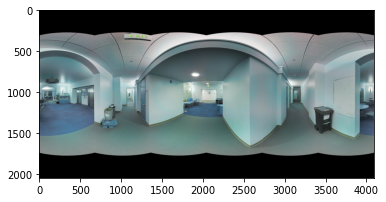

In [19]:
#plotting the spherical image to be used
plot_img_from_file(sph_file)

In [20]:
#setting parameters for the project
fov = 120
resolution = 300
interval = centroids


In [21]:
#loading the equirectangular panorama to the spherical projection
equ = E2P.Equirectangular(sph_file)

In [22]:
#creating the gnomonic projections
gnomonic_generation()

Sample Gnomonic image visualisation:

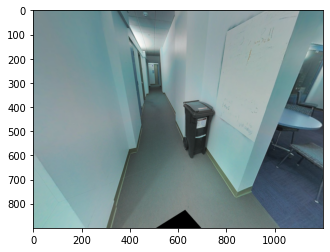

In [23]:
plot_img_from_file(sample_path+"gnomonic050.png")

In [24]:
project_name = CSAILVision_clone()

# CSAILVision_libraries:
from types import SimpleNamespace
import torch
!pip install git+https://github.com/CSAILVision/semantic-segmentation-pytorch.git@master
from mit_semseg.config import cfg
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion, parse_devices, setup_logger
from scipy.io import loadmat

ENCODER_NAME, DECODER_NAME, pretrained_encoder_file, pretrained_decoder_file = CSAILVision_model()
options, segmentation_module = CSAILVision_load()

semantic_segmentation_resnet101()


  Cloning https://github.com/CSAILVision/semantic-segmentation-pytorch.git (to revision master) to /tmp/pip-req-build-cs8q8anz
  Running command git clone -q https://github.com/CSAILVision/semantic-segmentation-pytorch.git /tmp/pip-req-build-cs8q8anz
  Created wheel for mit-semseg: filename=mit_semseg-1.0.0-cp36-none-any.whl size=46839 sha256=7968379dfa71e020613bcb2f0272ed2f95d7a7a2b752da4f191b0635e1e879b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ct17iea2/wheels/2e/60/c1/0265cf3ae457b106a50e8de5ccc739181a130d1608883c6989
Successfully built mit-semseg
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1
0
# samples: 1
1
# samples: 1
2
# samples: 1
3
# samples: 1
4
# samples: 1
5
# samples: 1
6
# samples: 1
7
# samples: 1
8
# samples: 1
9
# samples: 1
10
# samples: 1
11
# samples: 1
12
# samples: 1
13
# samples: 1
14
# samples: 1
15
# samples: 1
16
# samples: 1
17
# samples: 1
18
# samples: 1
19
# samples: 1
20
# samples: 1
21
# samples: 1
22
# samples: 1

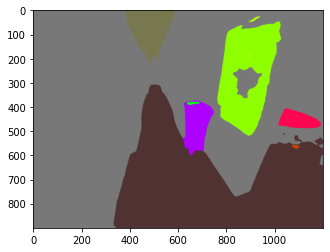

In [25]:
plot_img_from_file(segmented_path+"segmented050.png")

In [26]:
panorama, panorama_height, panorama_width, panorama_channels = panorama_size()
panorama_to_segmentation(sph_file)

# samples: 1
(2048, 4096, 3)


In [27]:
reproject_segmented_images()

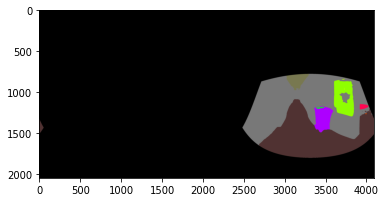

In [28]:
plot_img_from_file(out_path+'reprojected050.png')

In [29]:
reproject_segmented_confidence()

stack_reprojected = confidence_tensor()

torch_array = torch.as_tensor(stack_reprojected)

confidence, pred = torch.max(torch_array, dim=0)

61


In [30]:
print(confidence.shape)
print(confidence)
print(pred)
print(pred.shape)

torch.Size([2048, 4096])
tensor([[0.8765, 0.8765, 0.8765,  ..., 0.8765, 0.8765, 0.8765],
        [0.8770, 0.8770, 0.8770,  ..., 0.8770, 0.8770, 0.8770],
        [0.8770, 0.8770, 0.8770,  ..., 0.8770, 0.8770, 0.8770],
        ...,
        [0.9765, 0.9765, 0.9765,  ..., 0.9567, 0.9567, 0.9567],
        [0.9765, 0.9765, 0.9765,  ..., 0.9567, 0.9567, 0.9567],
        [0.9765, 0.9765, 0.9765,  ..., 0.9567, 0.9567, 0.9567]],
       dtype=torch.float64)
tensor([[53, 53, 53,  ..., 53, 53, 53],
        [53, 53, 53,  ..., 53, 53, 53],
        [53, 53, 53,  ..., 53, 53, 53],
        ...,
        [60, 60, 60,  ..., 60, 60, 60],
        [60, 60, 60,  ..., 60, 60, 60],
        [60, 60, 60,  ..., 60, 60, 60]])
torch.Size([2048, 4096])


In [31]:
np.save(project_path+"confidence.npy",confidence)
np.save(project_path+"pred.npy",pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


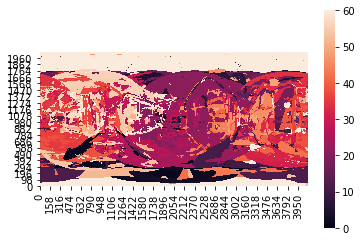

In [32]:
import seaborn as sns

sns.heatmap(pred, square=True)
plt.xlim(0, pred.shape[1])
plt.ylim(0, pred.shape[0])
plt.show()

In [33]:
from scipy.stats import mode as stats_mode

final_mode = generate_final_from_mode()
final_weight = generate_final_from_weight()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Found mode: [120 120 120]
(2048, 4096, 3)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


NameError: ignored

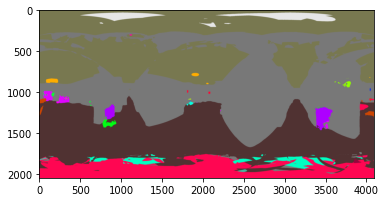

In [37]:
plot_img_from_np(final_mode)

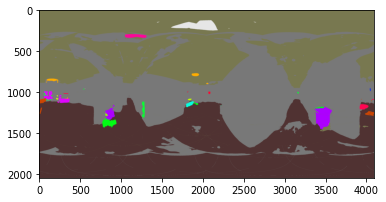

In [36]:
plot_img_from_np(final_weight)